In [42]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline


In [43]:
# Cell 2: Load the datasets
train_path = r'C:\Users\KIIT\Downloads\churn-bigml-80.csv'
test_path = r'C:\Users\KIIT\Downloads\churn-bigml-20.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
print(train_df.shape, test_df.shape)  # Expected: (2666, 20), (667, 20)


(2666, 20) (667, 20)


In [44]:
# Cell 3: Basic data overview
train_df.info()
print(train_df.isnull().sum())  # Should show no nulls
print(train_df['Churn'].value_counts(normalize=True))  # Churn rate ~14% (imbalanced)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

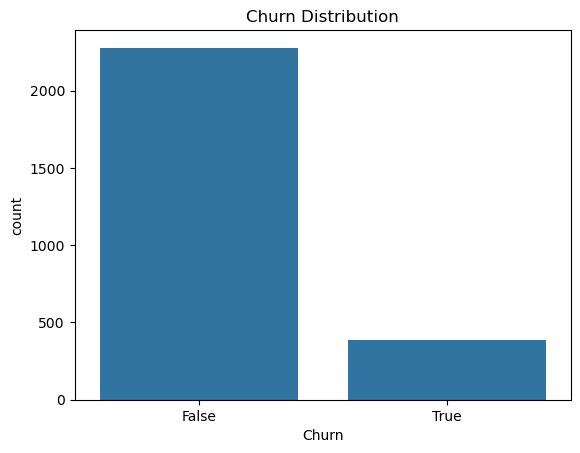

In [45]:
# Cell 4: EDA - Churn distribution visualization
sns.countplot(x='Churn', data=train_df)
plt.title('Churn Distribution')
plt.show()


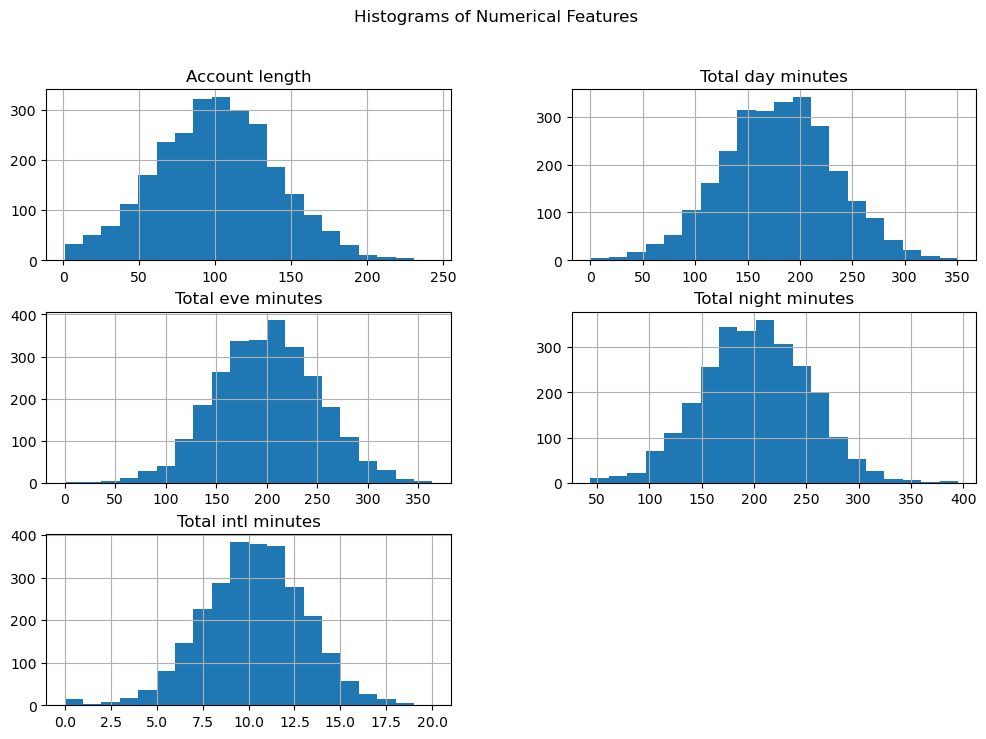

In [46]:
# Cell 5: Histograms for numerical features
numerical_features = ['Account length', 'Total day minutes', 'Total eve minutes', 'Total night minutes', 'Total intl minutes']
train_df[numerical_features].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms of Numerical Features')
plt.show()


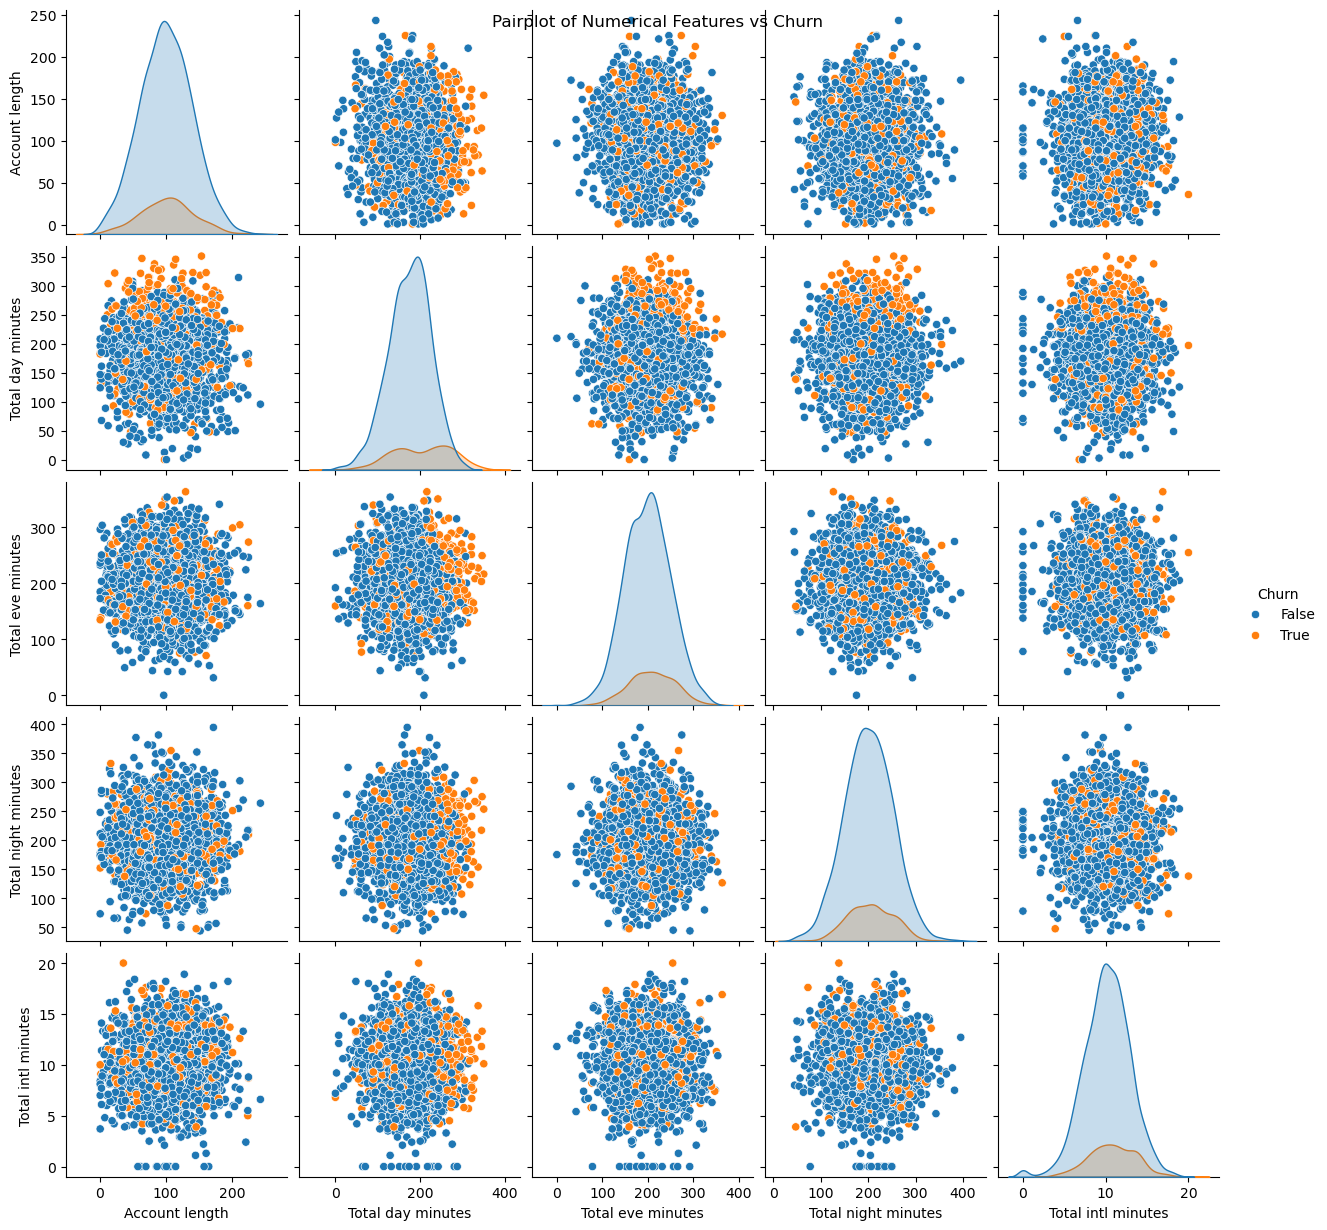

In [47]:
# Cell 6:Pairplot for feature relationships
sns.pairplot(train_df[numerical_features + ['Churn']], hue='Churn')
plt.suptitle('Pairplot of Numerical Features vs Churn')
plt.show()


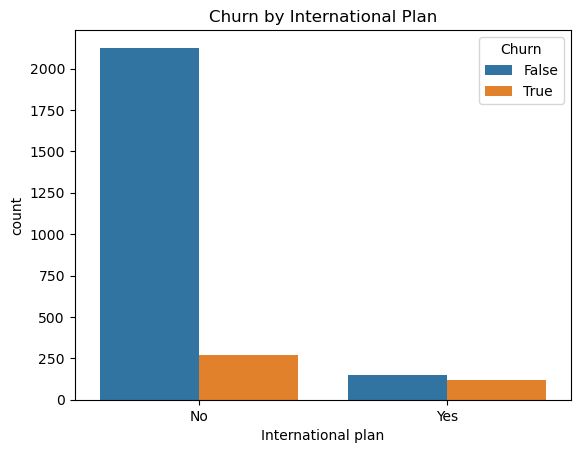

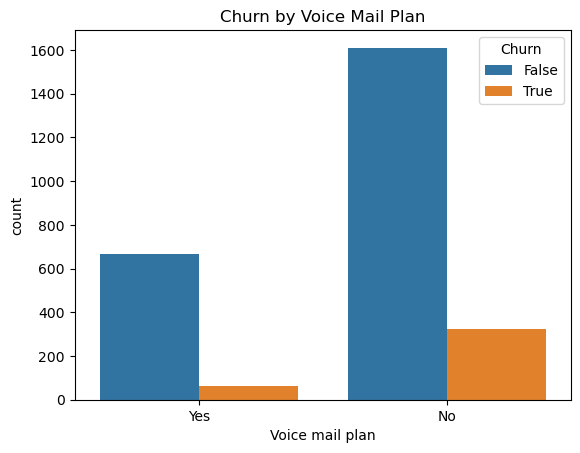

In [48]:
# Cell 7:Churn by categorical features
sns.countplot(x='International plan', hue='Churn', data=train_df)
plt.title('Churn by International Plan')
plt.show()

sns.countplot(x='Voice mail plan', hue='Churn', data=train_df)
plt.title('Churn by Voice Mail Plan')
plt.show()


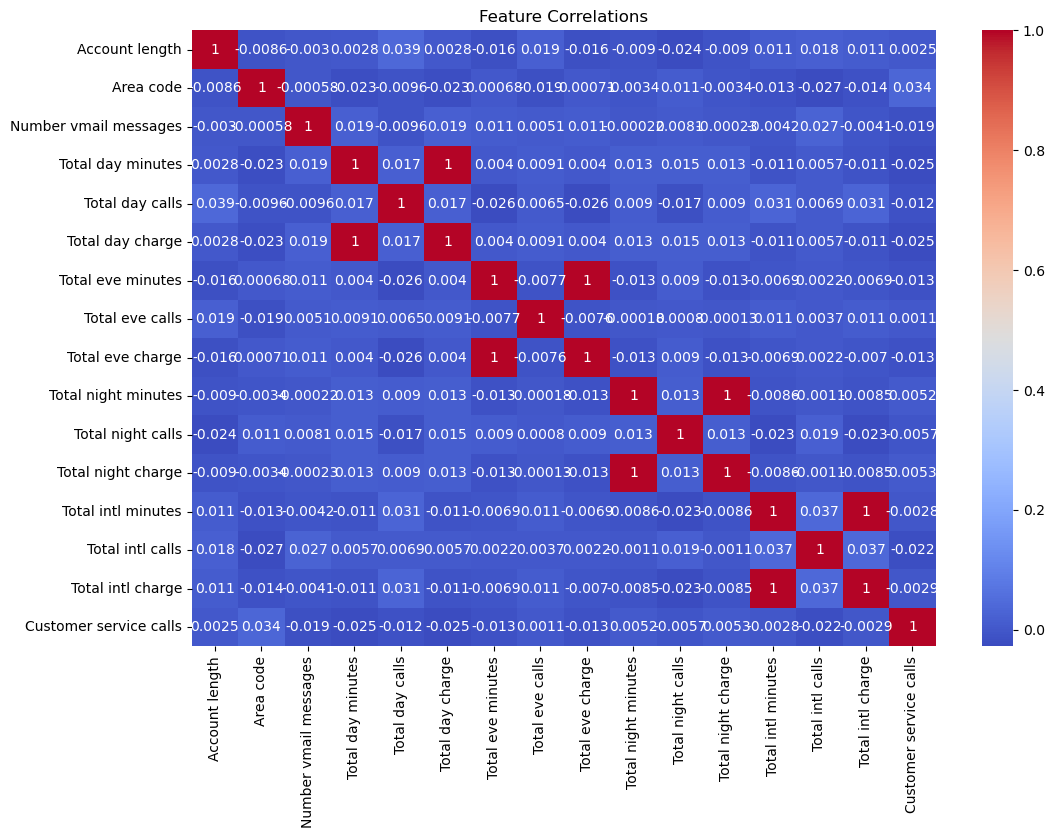

In [49]:
# Cell 8: EDA - Correlation heatmap
numeric_df = train_df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()


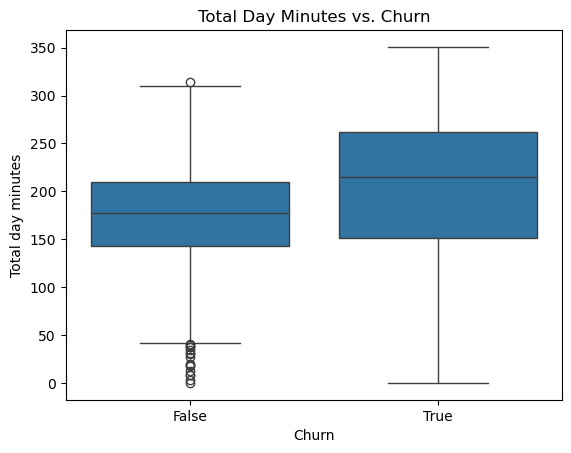

In [50]:
# Cell 9: EDA - Boxplot for key features vs. Churn
sns.boxplot(x='Churn', y='Total day minutes', data=train_df)
plt.title('Total Day Minutes vs. Churn')
plt.show()


In [51]:
# Cell 10: Feature engineering and preprocessing
def preprocess(df):
    df = df.copy()
    le = LabelEncoder()
    df['International plan'] = le.fit_transform(df['International plan'])
    df['Voice mail plan'] = le.fit_transform(df['Voice mail plan'])
    df.drop(['State', 'Area code'], axis=1, inplace=True)  # Low relevance
    df['Churn'] = df['Churn'].astype(int)  # Ensure binary
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

X_train = train_df.drop('Churn', axis=1)
y_train = train_df['Churn']
X_test = test_df.drop('Churn', axis=1)
y_test = test_df['Churn']
feature_names = X_train.columns  # Save for later use in feature importances


In [52]:
# Cell 11: Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [53]:
# Cell 12: Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(pd.Series(y_train_res).value_counts())  # Balanced now


Churn
0    2278
1    2278
Name: count, dtype: int64


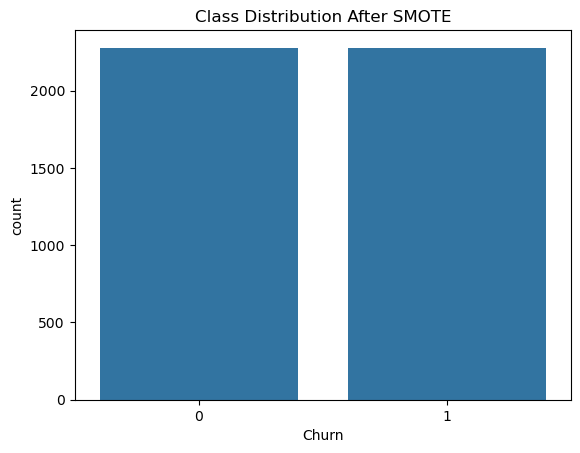

In [54]:
# Cell 13: Additional visualization - Class distribution after SMOTE
sns.countplot(x=y_train_res)
plt.title('Class Distribution After SMOTE')
plt.show()


In [55]:
# Cell 14: Function to evaluate models
def evaluate_model(y_true, y_pred, y_prob=None):
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred))
    print('Recall:', recall_score(y_true, y_pred))
    print('F1-Score:', f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    # Return correct predictions count (TP + TN)
    cm = confusion_matrix(y_true, y_pred)
    correct_preds = cm[0, 0] + cm[1, 1]
    return correct_preds


Best params: {'C': 10}
Accuracy: 0.7721139430284858
Precision: 0.35960591133004927
Recall: 0.7684210526315789
F1-Score: 0.4899328859060403
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       572
           1       0.36      0.77      0.49        95

    accuracy                           0.77       667
   macro avg       0.66      0.77      0.67       667
weighted avg       0.87      0.77      0.80       667



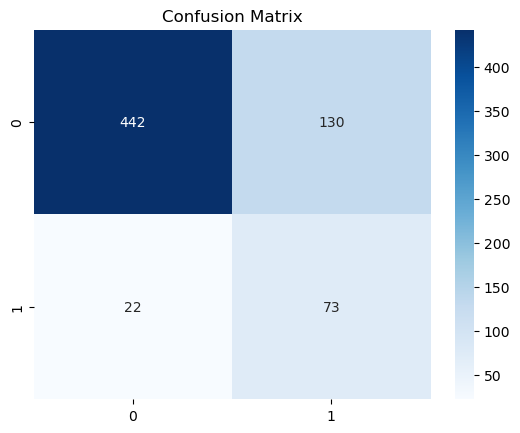

In [56]:
# Cell 15: Model 1 - Logistic Regression with tuning
param_grid_lr = {'C': [0.1, 1, 10]}
lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid_lr, cv=3)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]
print('Best params:', lr.best_params_)
correct_lr = evaluate_model(y_test, y_pred_lr, y_prob_lr)


Best params: {'max_depth': 20, 'n_estimators': 200}
Accuracy: 0.9460269865067467
Precision: 0.8041237113402062
Recall: 0.8210526315789474
F1-Score: 0.8125
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       572
           1       0.80      0.82      0.81        95

    accuracy                           0.95       667
   macro avg       0.89      0.89      0.89       667
weighted avg       0.95      0.95      0.95       667



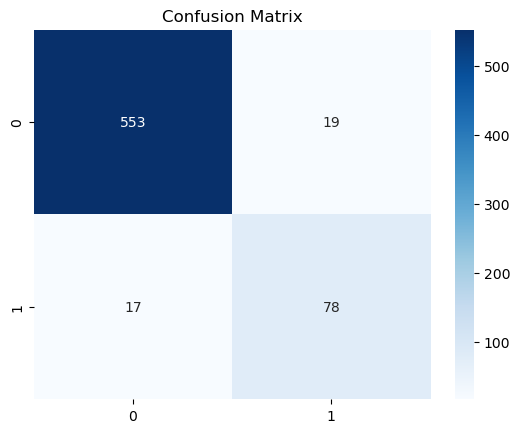

In [57]:
# Cell 16: Model 2 - Random Forest with tuning
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
print('Best params:', rf.best_params_)
correct_rf = evaluate_model(y_test, y_pred_rf, y_prob_rf)


Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.9430284857571214
Precision: 0.7938144329896907
Recall: 0.8105263157894737
F1-Score: 0.8020833333333334
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       572
           1       0.79      0.81      0.80        95

    accuracy                           0.94       667
   macro avg       0.88      0.89      0.88       667
weighted avg       0.94      0.94      0.94       667



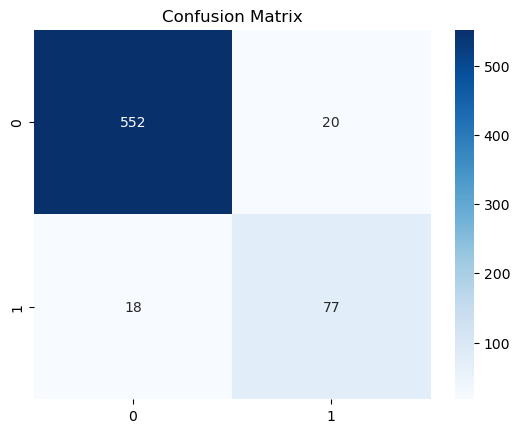

In [58]:
# Cell 17: Model 3 - XGBoost with tuning
param_grid_xgb = {'n_estimators': [100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.01]}
xgb = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'), param_grid_xgb, cv=3)
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]
print('Best params:', xgb.best_params_)
correct_xgb = evaluate_model(y_test, y_pred_xgb, y_prob_xgb)


[LightGBM] [Info] Number of positive: 1519, number of negative: 1518
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3827
[LightGBM] [Info] Number of data points in the train set: 3037, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500165 -> initscore=0.000659
[LightGBM] [Info] Start training from score 0.000659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

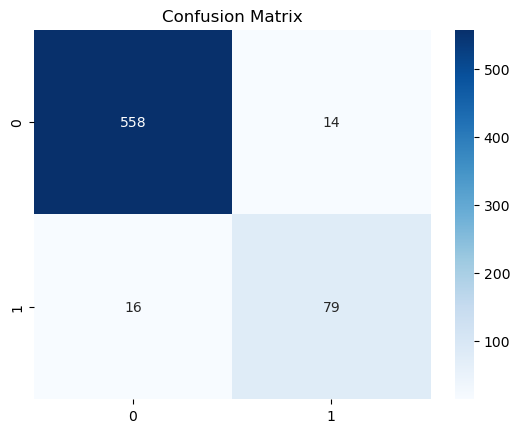

In [59]:
# Cell 18: Model 4 - LightGBM with tuning
param_grid_lgb = {'n_estimators': [100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.01]}
lgbm = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid_lgb, cv=3)
lgbm.fit(X_train_res, y_train_res)
y_pred_lgb = lgbm.predict(X_test)
y_prob_lgb = lgbm.predict_proba(X_test)[:, 1]
print('Best params:', lgbm.best_params_)
correct_lgb = evaluate_model(y_test, y_pred_lgb, y_prob_lgb)


Neural Network (PyTorch) evaluation:
Accuracy: 0.9190404797601199
Precision: 0.6814159292035398
Recall: 0.8105263157894737
F1-Score: 0.7403846153846154
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       572
           1       0.68      0.81      0.74        95

    accuracy                           0.92       667
   macro avg       0.82      0.87      0.85       667
weighted avg       0.93      0.92      0.92       667



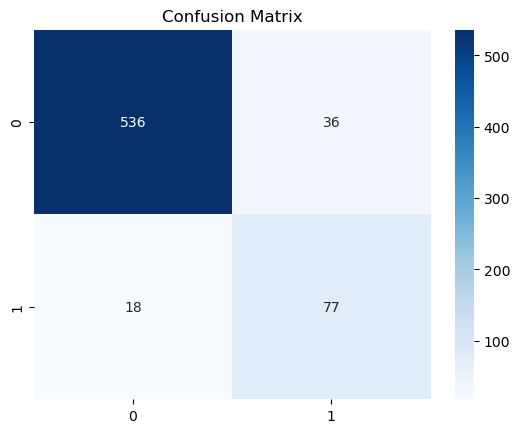

In [60]:
# Cell 19: Model 5 - Neural Network using PyTorch
class ChurnNN(nn.Module):
    def __init__(self, input_dim):
        super(ChurnNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res.values if hasattr(y_train_res, 'values') else y_train_res, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values if hasattr(y_test, 'values') else y_test, dtype=torch.float32).view(-1, 1)

# Instantiate the model
input_dim = X_train_tensor.shape[1]
model = ChurnNN(input_dim)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop settings
num_epochs = 50
batch_size = 32

# DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    # Optionally print epoch loss
    # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

# Model evaluation
model.eval()
with torch.no_grad():
    y_pred_prob_tensor = model(X_test_tensor).squeeze()
    y_pred_prob = y_pred_prob_tensor.numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate using earlier function
print('Neural Network (PyTorch) evaluation:')
correct_nn = evaluate_model(y_test, y_pred, y_pred_prob)


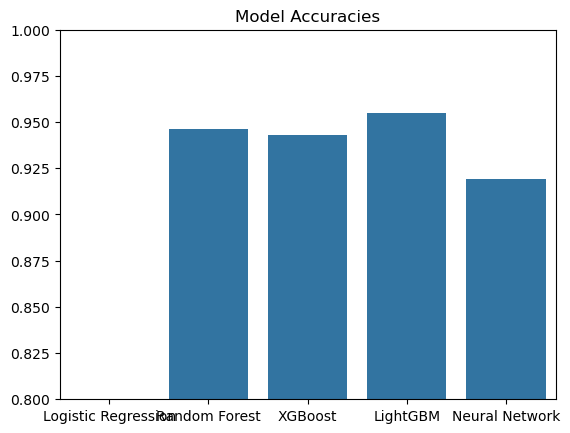

Highest accuracy: 0.9550224887556222


In [93]:
# Cell 20: Compare all models' accuracies 
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Neural Network']
accuracies = [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf),
              accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_lgb),
              accuracy_score(y_test, y_pred)]
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracies')
plt.ylim(0.8, 1.0)
plt.show()
print('Highest accuracy:', max(accuracies))


In [95]:
# Cell 21: Show which model gave correct predictions 
correct_predictions = {
    'Logistic Regression': correct_lr,
    'Random Forest': correct_rf,
    'XGBoost': correct_xgb,
    'LightGBM': correct_lgb,
    'Neural Network': correct_nn
}
best_model = max(correct_predictions, key=correct_predictions.get)
print('Number of correct predictions by model:')
for model, count in correct_predictions.items():
    print(f'{model}: {count} correct out of {len(y_test)}')
print(f'\nThe model with the most correct predictions is: {best_model} ({correct_predictions[best_model]} correct)')


Number of correct predictions by model:
Logistic Regression: 515 correct out of 667
Random Forest: 631 correct out of 667
XGBoost: 629 correct out of 667
LightGBM: 637 correct out of 667
Neural Network: 613 correct out of 667

The model with the most correct predictions is: LightGBM (637 correct)


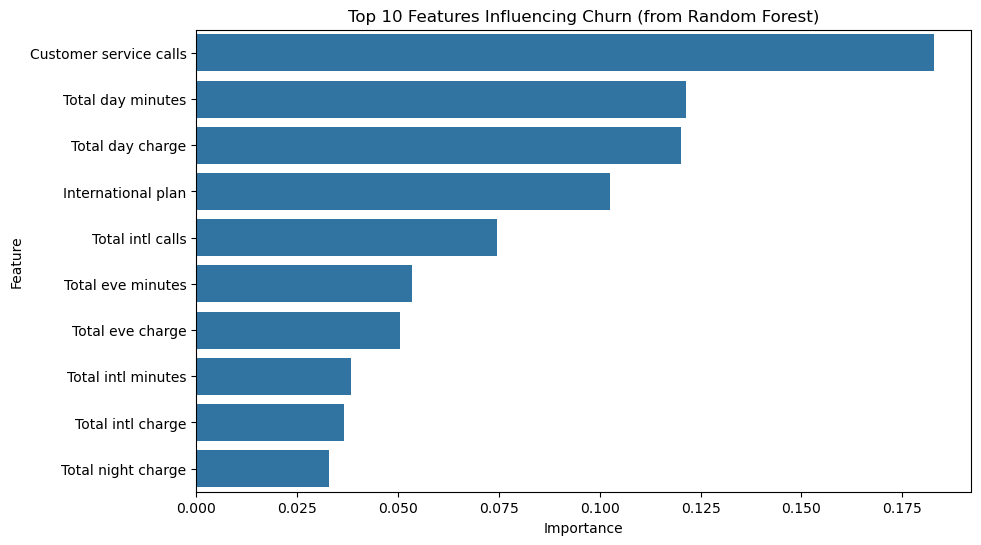

Retention Suggestions Based on Key Features:
- For Customer service calls: Offer usage-based discounts or loyalty rewards to high-usage customers to reduce churn risk.
- For Total day minutes: Offer usage-based discounts or loyalty rewards to high-usage customers to reduce churn risk.
- For Total day charge: Introduce cost-saving bundles or promotions to lower perceived costs for price-sensitive users.
- For International plan: Promote affordable international add-ons or free trials to encourage adoption and retention.
- For Total intl calls: Offer usage-based discounts or loyalty rewards to high-usage customers to reduce churn risk.


In [63]:
# Cell 22: Retention suggestions according to features
# Extract feature importances from Random Forest (as it's tree-based and interpretable)
importances = rf.best_estimator_.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Features Influencing Churn (from Random Forest)')
plt.show()

# Generate retention suggestions based on top features
print('Retention Suggestions Based on Key Features:')
top_features = feature_importance_df.head(5)['Feature'].tolist()
for feature in top_features:
    if 'minutes' in feature.lower() or 'calls' in feature.lower():
        print(f'- For {feature}: Offer usage-based discounts or loyalty rewards to high-usage customers to reduce churn risk.')
    elif 'charge' in feature.lower():
        print(f'- For {feature}: Introduce cost-saving bundles or promotions to lower perceived costs for price-sensitive users.')
    elif 'international' in feature.lower():
        print(f'- For {feature}: Promote affordable international add-ons or free trials to encourage adoption and retention.')
    elif 'voice mail' in feature.lower():
        print(f'- For {feature}: Provide free voice mail upgrades or tutorials to increase engagement and satisfaction.')
    elif 'customer service' in feature.lower():
        print(f'- For {feature}: Improve support response times and offer proactive check-ins for frequent callers to boost loyalty.')
    else:
        print(f'- For {feature}: Monitor and personalize offers based on usage patterns to enhance retention.')


Average Retention Probability on Test Set (using LightGBM): 82.27%


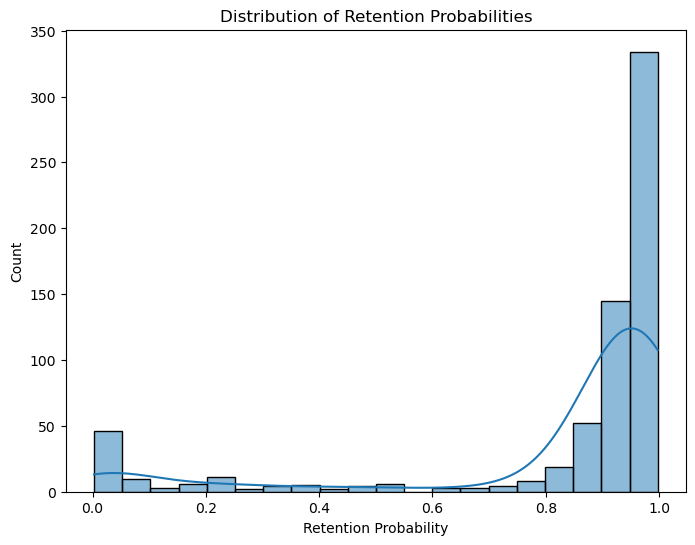

In [64]:
# Cell 23: Calculate retention probability (new)
# Select the best model based on previous comparison
model_dict = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'XGBoost': xgb,
    'LightGBM': lgbm,
    'Neural Network': model  # PyTorch model
}

best_model_instance = model_dict[best_model]

# Get churn probabilities using the best model
if best_model == 'Neural Network':
    with torch.no_grad():
        churn_prob = model(X_test_tensor).squeeze().numpy()
else:
    churn_prob = best_model_instance.predict_proba(X_test)[:, 1]

# Calculate retention probability (1 - churn prob)
retention_prob = 1 - churn_prob

# Display average retention probability
print(f'Average Retention Probability on Test Set (using {best_model}): {retention_prob.mean():.2%}')

# Visualize distribution
plt.figure(figsize=(8, 6))
sns.histplot(retention_prob, bins=20, kde=True)
plt.title('Distribution of Retention Probabilities')
plt.xlabel('Retention Probability')
plt.ylabel('Count')
plt.show()


In [65]:
# Cell 24: Retention strategies based on probabilities (new)
# Segment users based on retention probability
high_retention = (retention_prob > 0.8).sum()
medium_retention = ((retention_prob > 0.5) & (retention_prob <= 0.8)).sum()
low_retention = (retention_prob <= 0.5).sum()

print(f'Segmentation:\n- High Retention (>80% prob): {high_retention} users\n- Medium Retention (50-80% prob): {medium_retention} users\n- Low Retention (<=50% prob): {low_retention} users')

# Strategies
print('\nRetention Strategies:')
print('- High Retention: Maintain loyalty with rewards programs or exclusive perks to encourage referrals.')
print('- Medium Retention: Send personalized offers, such as discounts on next billing cycle, to boost engagement.')
print('- Low Retention: Prioritize outreach with surveys, free upgrades, or dedicated support to address pain points and prevent churn.')


Segmentation:
- High Retention (>80% prob): 550 users
- Medium Retention (50-80% prob): 24 users
- Low Retention (<=50% prob): 93 users

Retention Strategies:
- High Retention: Maintain loyalty with rewards programs or exclusive perks to encourage referrals.
- Medium Retention: Send personalized offers, such as discounts on next billing cycle, to boost engagement.
- Low Retention: Prioritize outreach with surveys, free upgrades, or dedicated support to address pain points and prevent churn.


In [66]:
# Cell 25: Prediction on new data (LightGBM only), with churn probability printed alongside retention suggestions
# Function to predict using LightGBM and suggest retention actions based on probability ranges
def predict_and_suggest(new_data):
    # Preprocess and scale new data (assuming same features as X_test)
    new_data = pd.DataFrame(new_data, columns=feature_names)
    new_data = scaler.transform(new_data)
    
    pred_prob = lgbm.predict_proba(new_data)[:, 1]
    pred = (pred_prob > 0.5).astype(int)
    
    # Retention suggestions based on churn probability ranges
    suggestions = []
    for i, prob in enumerate(pred_prob):
        if 0 <= prob <= 0.3:
            suggestions.append(f'Customer {i+1}: Churn Probability={prob:.2f} - Very low risk. Reward with loyalty perks or referral bonuses to maintain engagement.')
        elif 0.31 <= prob <= 0.5:
            suggestions.append(f'Customer {i+1}: Churn Probability={prob:.2f} - Low risk. Send personalized usage tips or minor discounts to reinforce satisfaction.')
        elif 0.51 <= prob <= 0.8:
            suggestions.append(f'Customer {i+1}: Churn Probability={prob:.2f} - Medium risk. Offer targeted promotions like bundle upgrades or feedback surveys to address potential issues.')
        elif 0.81 <= prob <= 1:
            suggestions.append(f'Customer {i+1}: Churn Probability={prob:.2f} - High risk. Prioritize immediate outreach with free trials, dedicated support, or significant discounts to prevent loss.')
    
    return pred, pred_prob, suggestions

# 10 varied sample data points (synthetic examples for demonstration; adjust as needed)
sample_data = [
    {'Account length': 100, 'International plan': 0, 'Voice mail plan': 1, 'Number vmail messages': 20, 'Total day minutes': 150, 'Total day calls': 80, 'Total day charge': 25.5, 'Total eve minutes': 160, 'Total eve calls': 90, 'Total eve charge': 13.6, 'Total night minutes': 170, 'Total night calls': 85, 'Total night charge': 7.65, 'Total intl minutes': 5, 'Total intl calls': 2, 'Total intl charge': 1.35, 'Customer service calls': 1},
    {'Account length': 50, 'International plan': 0, 'Voice mail plan': 0, 'Number vmail messages': 0, 'Total day minutes': 250, 'Total day calls': 120, 'Total day charge': 42.5, 'Total eve minutes': 200, 'Total eve calls': 110, 'Total eve charge': 17.0, 'Total night minutes': 180, 'Total night calls': 95, 'Total night charge': 8.1, 'Total intl minutes': 15, 'Total intl calls': 10, 'Total intl charge': 4.05, 'Customer service calls': 4},
    {'Account length': 120, 'International plan': 1, 'Voice mail plan': 0, 'Number vmail messages': 0, 'Total day minutes': 180, 'Total day calls': 100, 'Total day charge': 30.6, 'Total eve minutes': 190, 'Total eve calls': 100, 'Total eve charge': 16.15, 'Total night minutes': 200, 'Total night calls': 90, 'Total night charge': 9.0, 'Total intl minutes': 10, 'Total intl calls': 5, 'Total intl charge': 2.7, 'Customer service calls': 2},
    {'Account length': 80, 'International plan': 0, 'Voice mail plan': 0, 'Number vmail messages': 0, 'Total day minutes': 300, 'Total day calls': 130, 'Total day charge': 51.0, 'Total eve minutes': 220, 'Total eve calls': 120, 'Total eve charge': 18.7, 'Total night minutes': 210, 'Total night calls': 100, 'Total night charge': 9.45, 'Total intl minutes': 12, 'Total intl calls': 8, 'Total intl charge': 3.24, 'Customer service calls': 3},
    {'Account length': 150, 'International plan': 1, 'Voice mail plan': 1, 'Number vmail messages': 30, 'Total day minutes': 100, 'Total day calls': 70, 'Total day charge': 17.0, 'Total eve minutes': 120, 'Total eve calls': 80, 'Total eve charge': 10.2, 'Total night minutes': 140, 'Total night calls': 75, 'Total night charge': 6.3, 'Total intl minutes': 8, 'Total intl calls': 3, 'Total intl charge': 2.16, 'Customer service calls': 0},
    {'Account length': 90, 'International plan': 0, 'Voice mail plan': 1, 'Number vmail messages': 15, 'Total day minutes': 200, 'Total day calls': 110, 'Total day charge': 34.0, 'Total eve minutes': 180, 'Total eve calls': 95, 'Total eve charge': 15.3, 'Total night minutes': 190, 'Total night calls': 85, 'Total night charge': 8.55, 'Total intl minutes': 9, 'Total intl calls': 4, 'Total intl charge': 2.43, 'Customer service calls': 5},
    {'Account length': 110, 'International plan': 0, 'Voice mail plan': 1, 'Number vmail messages': 25, 'Total day minutes': 160, 'Total day calls': 90, 'Total day charge': 27.2, 'Total eve minutes': 170, 'Total eve calls': 85, 'Total eve charge': 14.45, 'Total night minutes': 160, 'Total night calls': 80, 'Total night charge': 7.2, 'Total intl minutes': 6, 'Total intl_calls': 3, 'Total intl charge': 1.62, 'Customer service calls': 1},
    {'Account length': 60, 'International plan': 0, 'Voice mail plan': 0, 'Number vmail messages': 0, 'Total day minutes': 220, 'Total day calls': 115, 'Total day charge': 37.4, 'Total eve minutes': 210, 'Total eve calls': 105, 'Total eve charge': 17.85, 'Total night minutes': 200, 'Total night calls': 90, 'Total night charge': 9.0, 'Total intl minutes': 20, 'Total intl calls': 12, 'Total intl charge': 5.4, 'Customer service calls': 2},
    {'Account length': 130, 'International plan': 1, 'Voice mail plan': 0, 'Number vmail messages': 0, 'Total day minutes': 140, 'Total day calls': 75, 'Total day charge': 23.8, 'Total eve minutes': 150, 'Total eve calls': 80, 'Total eve charge': 12.75, 'Total night minutes': 250, 'Total night calls': 110, 'Total night charge': 11.25, 'Total intl minutes': 7, 'Total intl calls': 4, 'Total intl charge': 1.89, 'Customer service calls': 1},
    {'Account length': 70, 'International plan': 0, 'Voice mail plan': 0, 'Number vmail messages': 0, 'Total day minutes': 280, 'Total day calls': 125, 'Total day charge': 47.6, 'Total eve minutes': 240, 'Total eve calls': 115, 'Total eve charge': 20.4, 'Total night minutes': 220, 'Total night calls': 100, 'Total night charge': 9.9, 'Total intl minutes': 14, 'Total intl calls': 9, 'Total intl charge': 3.78, 'Customer service calls': 4}
]

predictions, probabilities, retention_suggestions = predict_and_suggest(sample_data)
print('Example Predictions (0: Retain, 1: Churn):', predictions)
#print('Churn Probabilities:', probabilities)
print('\nRetention Suggestions:')
for suggestion in retention_suggestions:
    print(suggestion)


Example Predictions (0: Retain, 1: Churn): [0 0 0 1 0 0 0 0 0 1]

Retention Suggestions:
Customer 1: Churn Probability=0.02 - Very low risk. Reward with loyalty perks or referral bonuses to maintain engagement.
Customer 2: Churn Probability=0.25 - Very low risk. Reward with loyalty perks or referral bonuses to maintain engagement.
Customer 3: Churn Probability=0.04 - Very low risk. Reward with loyalty perks or referral bonuses to maintain engagement.
Customer 4: Churn Probability=0.99 - High risk. Prioritize immediate outreach with free trials, dedicated support, or significant discounts to prevent loss.
Customer 5: Churn Probability=0.05 - Very low risk. Reward with loyalty perks or referral bonuses to maintain engagement.
Customer 6: Churn Probability=0.17 - Very low risk. Reward with loyalty perks or referral bonuses to maintain engagement.
Customer 7: Churn Probability=0.07 - Very low risk. Reward with loyalty perks or referral bonuses to maintain engagement.
Customer 8: Churn Prob